# Занятие 1. Введение в uplift-моделирование

Описание клиента до рассылки

* Recency: Months since last purchase.
* History_Segment: Categorization of dollars spent in the past year.
* History: Actual dollar value spent in the past year.
* Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
* Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
* Zip_Code: Classifies zip code as Urban, Suburban, or Rural.
* Newbie: 1/0 indicator, 1 = New customer in the past twelve months.
* Channel: Describes the channels the customer purchased from in the past year.


В этой переменной указано то, к какой группе был отнесен клиент
* Segment ("Mens E-Mail", "Womens E-Mail", "No E-Mail")

Переменные, описывающие клиента в течение 2 недель после получения e-mail

* Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks.
* Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
* Spend: Actual dollars spent in the following two weeks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from typing import List

In [63]:
import sklift.metrics
import sklift.viz

import pylift_utils

In [64]:
import catboost as cb
import pylift
import causalml.metrics as cmetrics

from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import train_test_split

# Required libs

In [65]:
def dict_coalesce(left_dict: dict, right_dict: dict) -> None:
    for key, value in right_dict.items():
        if key not in left_dict:
            left_dict[key] = value

class FunctionWrapper(object):
    def __init__(self, function, **params):
        self.params = params
        self.function = function

    def __call__(self, *args, **kwargs):
        dict_coalesce(kwargs, self.params)
        return self.function(*args, **kwargs)

In [66]:
def get_shap_values_(upmodel: pylift.TransformedOutcome):
    return upmodel.model.get_feature_importance(
        data=cb.Pool(
            data=upmodel.x_test,
            label=upmodel.transformed_y_test
        ),
        fstr_type='ShapValues'
    )

# Load data

In [67]:
data = pd.read_csv('data/part3/less1/1 Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

In [68]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [69]:
data['segment'].value_counts()

Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: segment, dtype: int64

In [70]:
data_womens = data.query('segment in ("No E-Mail", "Womens E-Mail")')

In [71]:
data_womens['treatment'] = (data_womens['segment'] == "Womens E-Mail").astype('int32')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
data_liar = data.query('segment in ("No E-Mail", "Womens E-Mail")')
data_liar['treatment'] = (data_liar['segment'] == "Womens E-Mail").astype('int32')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [73]:
data_womens.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0,1
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0,1


# Explore data

In [74]:
data_womens.shape

(42693, 13)

In [75]:
data_womens['zip_code'].value_counts()

Surburban    19275
Urban        17098
Rural         6320
Name: zip_code, dtype: int64

In [76]:
data_womens['channel'].value_counts()

Phone           18781
Web             18727
Multichannel     5185
Name: channel, dtype: int64

# Transform data

In [77]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, pd.get_dummies(data[cols])], axis=1)
    return result

In [78]:
def transform_(data: pd.DataFrame) -> pd.DataFrame:
    zipcode_num_dict = {
        'Urban': 0,
        'Surburban': 1,
        'Rural': 2
    }
    data['zip_code_num'] = data['zip_code'].apply(lambda s: zipcode_num_dict[s])
    
    channel_num_dict = {
        'Web': 0,
        'Multichannel': 1,
        'Phone': 2
    }
    data['channel_num'] = data['channel'].apply(lambda s: channel_num_dict[s])
    data['history_segment__label'] = data['history_segment'].apply(lambda s: s[0])
    data = one_hot_encode(data, cols=['zip_code', 'channel', 'history_segment__label'])
    return data

In [79]:
data_womens = transform_(data_womens)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
data_womens.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,...,channel_Multichannel,channel_Phone,channel_Web,history_segment__label_1,history_segment__label_2,history_segment__label_3,history_segment__label_4,history_segment__label_5,history_segment__label_6,history_segment__label_7
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,...,0,1,0,0,1,0,0,0,0,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,...,0,0,1,0,0,1,0,0,0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,...,0,0,1,0,1,0,0,0,0,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,...,0,0,1,1,0,0,0,0,0,0
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,...,0,1,0,0,1,0,0,0,0,0


### fit / validation split

In [20]:
fit_index, val_index = train_test_split(data_womens.index, test_size=0.5, random_state=148)

### column sets

In [21]:
data_womens.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend',
       'treatment', 'zip_code_num', 'channel_num', 'history_segment__label',
       'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
       'channel_Multichannel', 'channel_Phone', 'channel_Web',
       'history_segment__label_1', 'history_segment__label_2',
       'history_segment__label_3', 'history_segment__label_4',
       'history_segment__label_5', 'history_segment__label_6',
       'history_segment__label_7'],
      dtype='object')

In [22]:
column_set_n1 = [
    'recency',
    'history',
    'mens',
    'womens',
    'zip_code_num',
    'channel_num'
]

In [23]:
column_set_n2 = [
    'recency',
    'mens',
    'womens',
    'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web',
    'history_segment__label_1', 'history_segment__label_2',
    'history_segment__label_3', 'history_segment__label_4',
    'history_segment__label_5', 'history_segment__label_6',
    'history_segment__label_7'
]

# Transformed outcome
* Трансформация таргета

In [24]:
uplift_model_n0 = pylift.TransformedOutcome(
    data_womens.loc[fit_index, column_set_n1 + ['treatment', 'visit']],
    col_treatment='treatment', col_outcome='visit',
    test_size=2
)

In [25]:
uplift_model_n0.transformed_y_train

52917        -0.0
2950     1.993277
22171        -0.0
40261         0.0
29214         0.0
           ...   
51532         0.0
2082          0.0
56001   -2.006769
46130        -0.0
3082         -0.0
Name: TransformedOutcome, Length: 21344, dtype: object

In [26]:
uplift_model_n0.fit()

invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide


In [27]:
uplift_model_n0.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
eval_data = data_womens.loc[fit_index, column_set_n1 + ['treatment', 'visit']]
eval_data['score'] = uplift_model_n0.model.predict(eval_data[column_set_n1])
eval_data = eval_data[['score', 'treatment', 'visit']]

<Axes: xlabel='score', ylabel='Count'>

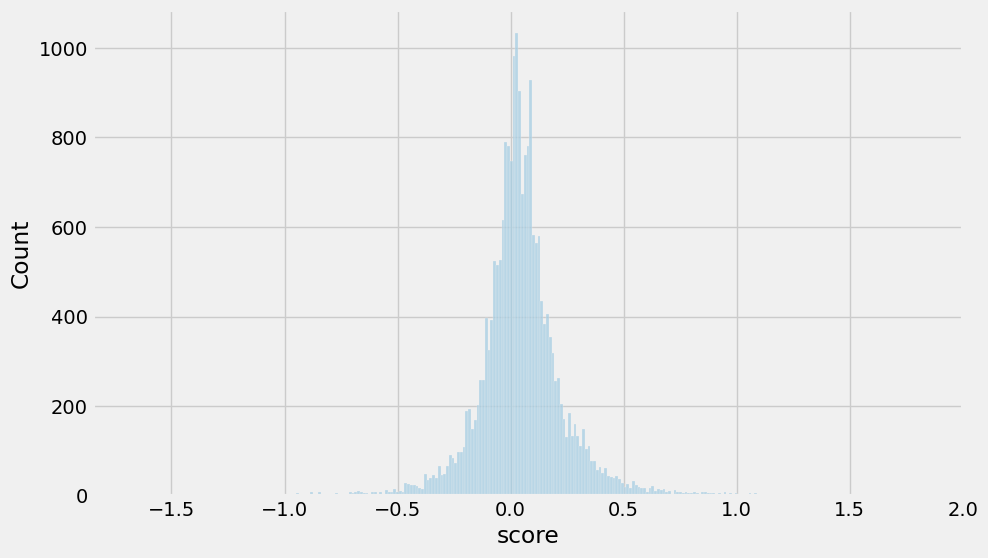

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data.score)

In [30]:
eval_data.score.mean()

0.04646361246705055

### Оценка качества

In [33]:
import causalml.metrics as cmetrics

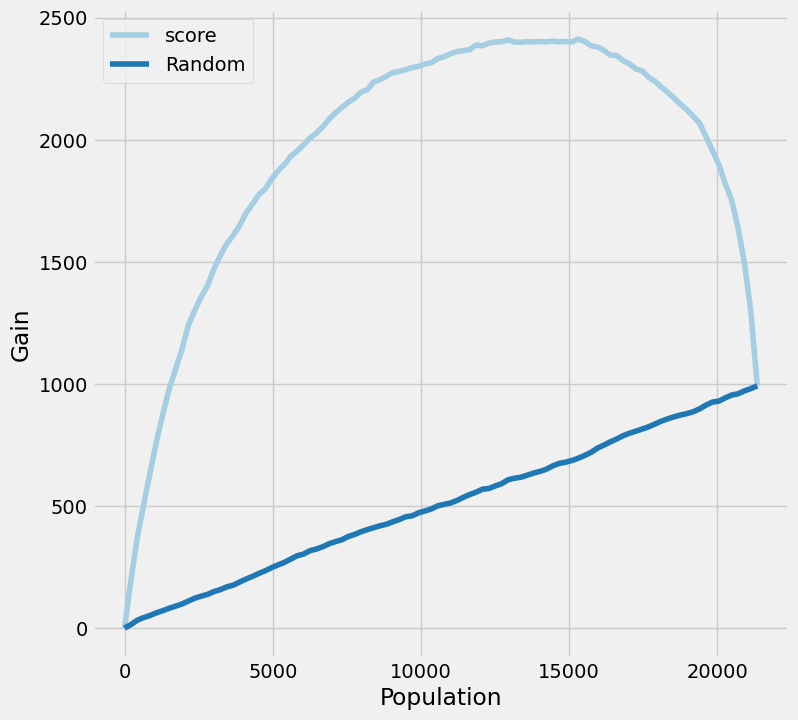

In [34]:
cmetrics.plot_gain(
    eval_data,
    treatment_col='treatment',
    outcome_col='visit'
)

In [36]:
upeval = pylift.eval.UpliftEval(
    treatment=eval_data['treatment'],
    outcome=eval_data['visit'],
    prediction=eval_data['score'],
    n_bins=10
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


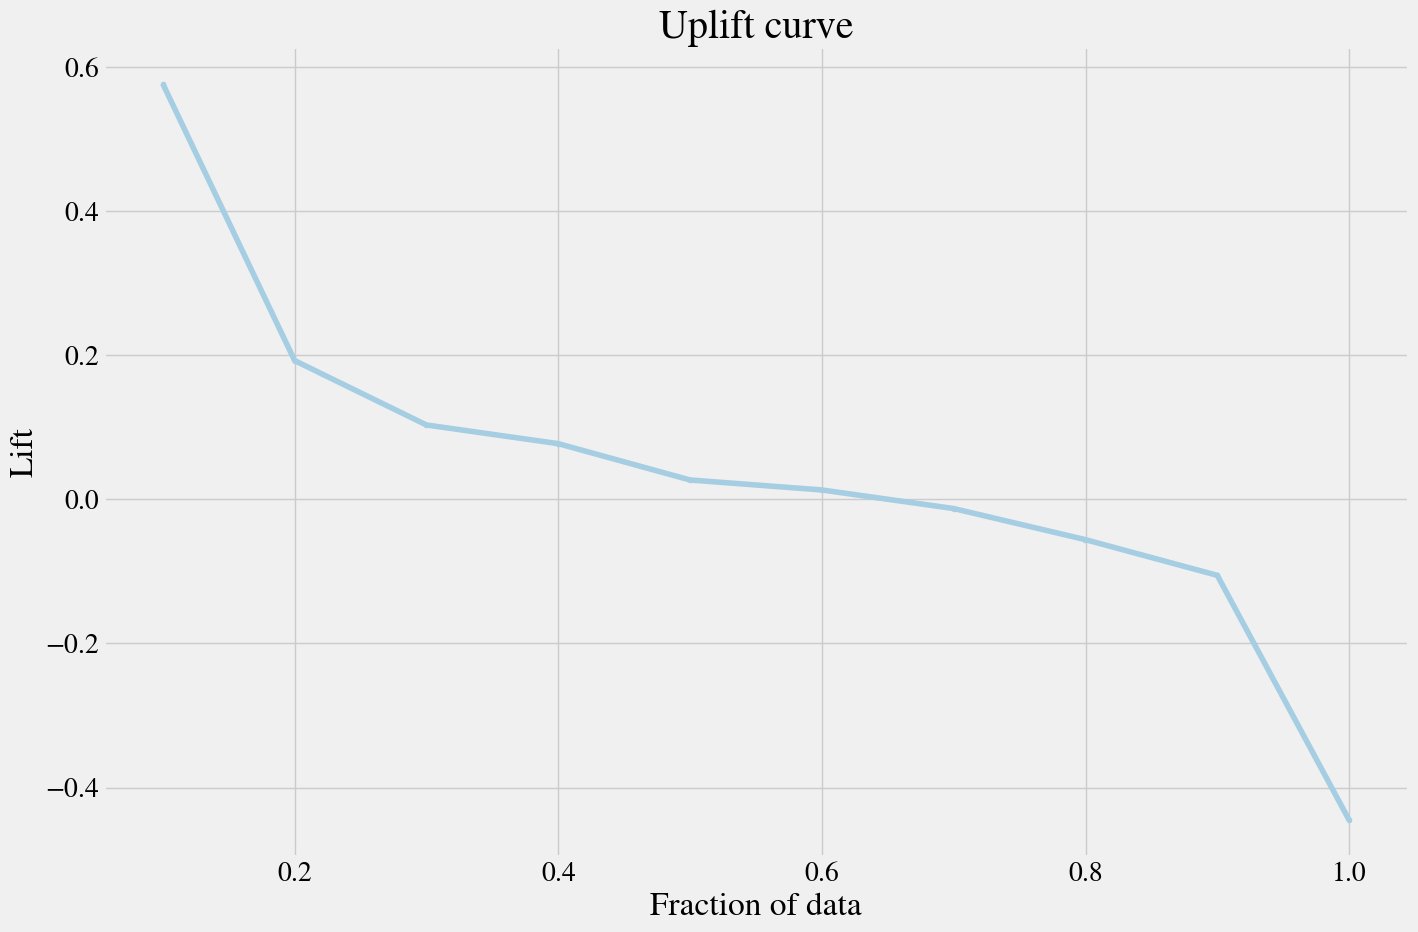

In [38]:
upeval.plot_uplift();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


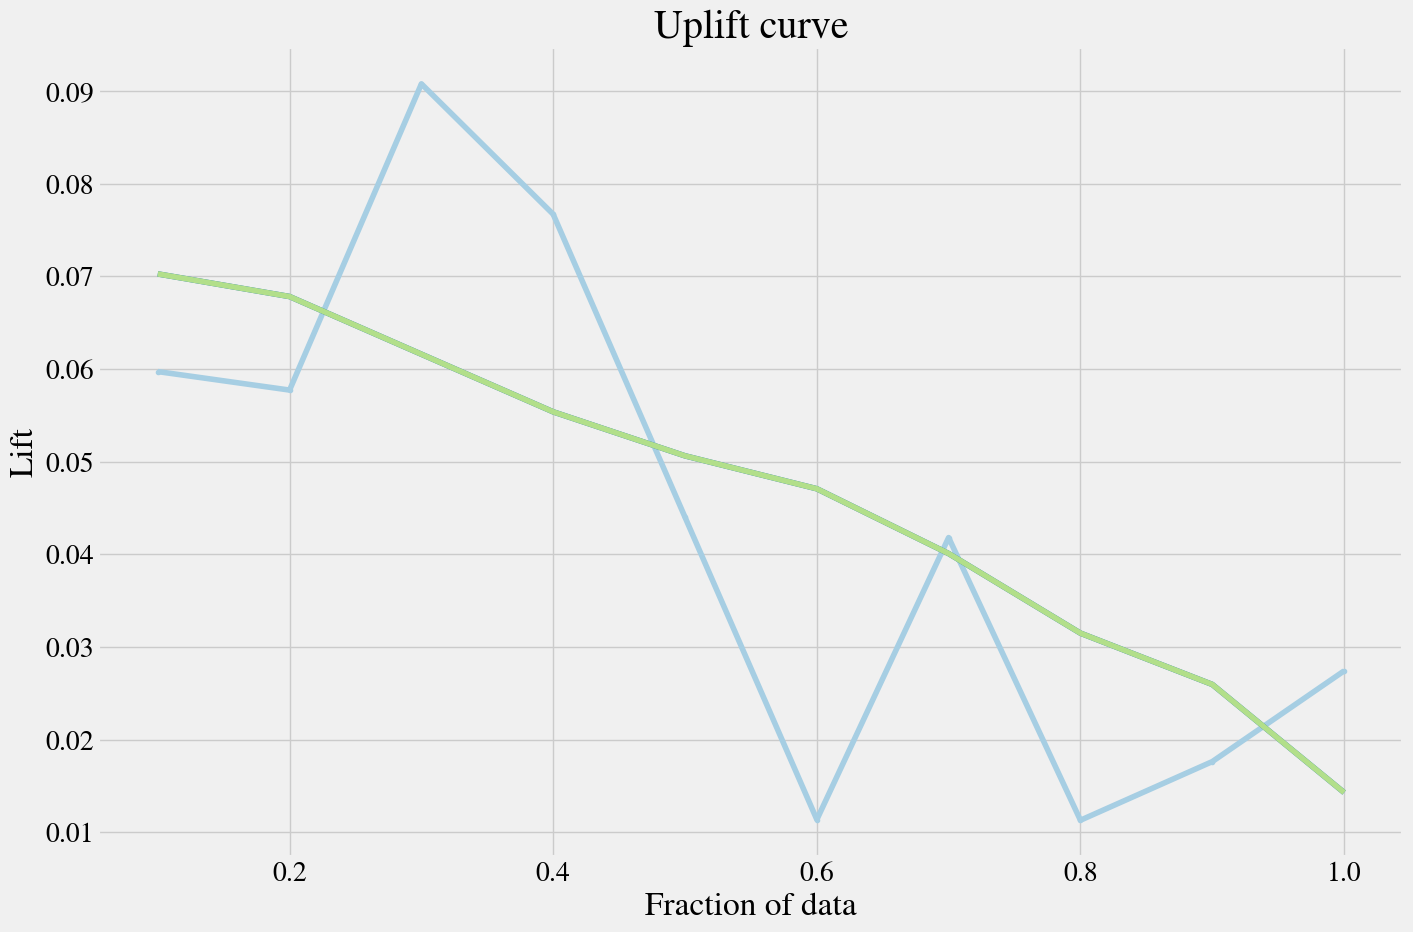

In [83]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10));

### Trees

In [46]:
from causalml.inference.tree import UpliftRandomForestClassifier

In [47]:
upmodel_rf = UpliftRandomForestClassifier(
    control_name='control',
    # evaluationFunction='CTS',
    n_estimators=10,
    max_depth=4,
    min_samples_leaf=500
    
)

In [50]:
 upmodel_rf.fit(
     X=data_womens.loc[fit_index, column_set_n1].values,
     treatment=data_womens.loc[fit_index, 'treatment'].apply(lambda t: 'treatment' if t == 1 else 'control').values,
     y=data_womens.loc[fit_index, 'visit'].values
 )

In [52]:
eval_data = data_womens.loc[val_index, column_set_n1 + ['treatment', 'visit']]
eval_data['score'] = upmodel_rf.predict(eval_data[column_set_n1].values)
eval_date = eval_data[['score', 'treatment', 'visit']]

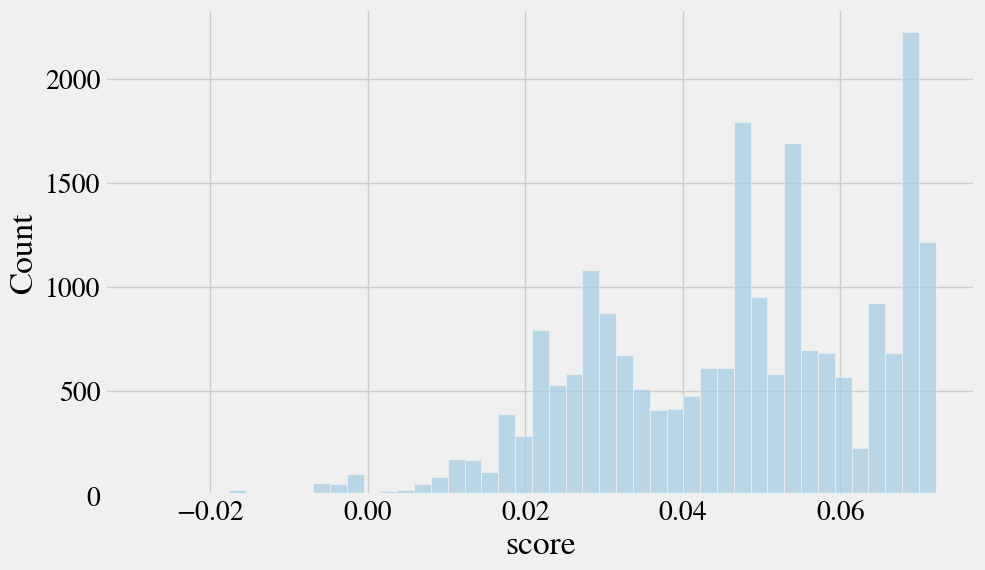

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(eval_data['score'])
plt.show()

#### Оценка качества

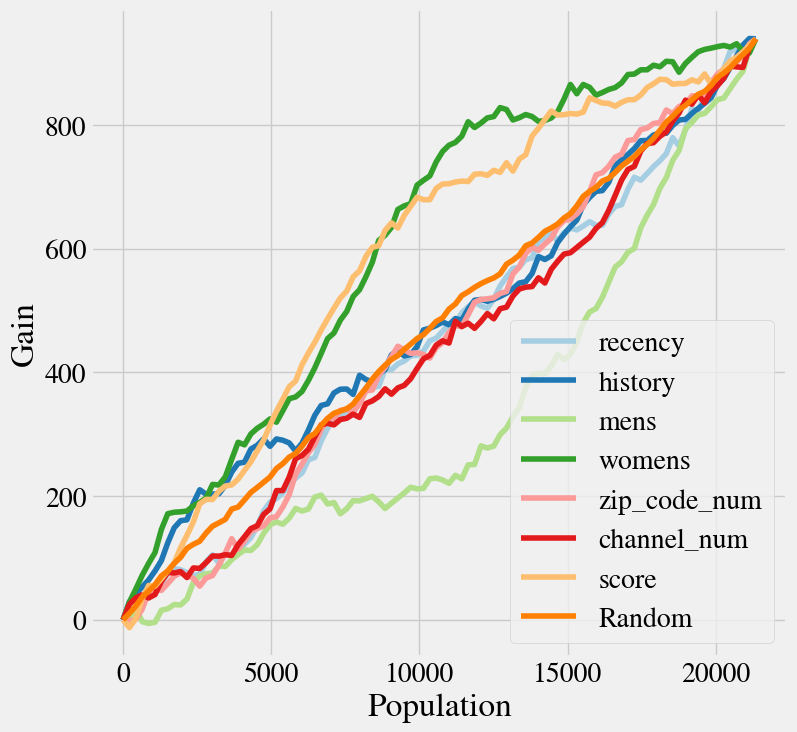

In [54]:
cmetrics.plot_gain(
    eval_data,
    treatment_col='treatment',
    outcome_col='visit',
)

In [55]:
upeval = pylift.eval.UpliftEval(
    treatment=eval_data['treatment'],
    outcome=eval_data['visit'],
    prediction=eval_data['score'],
    n_bins=10
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


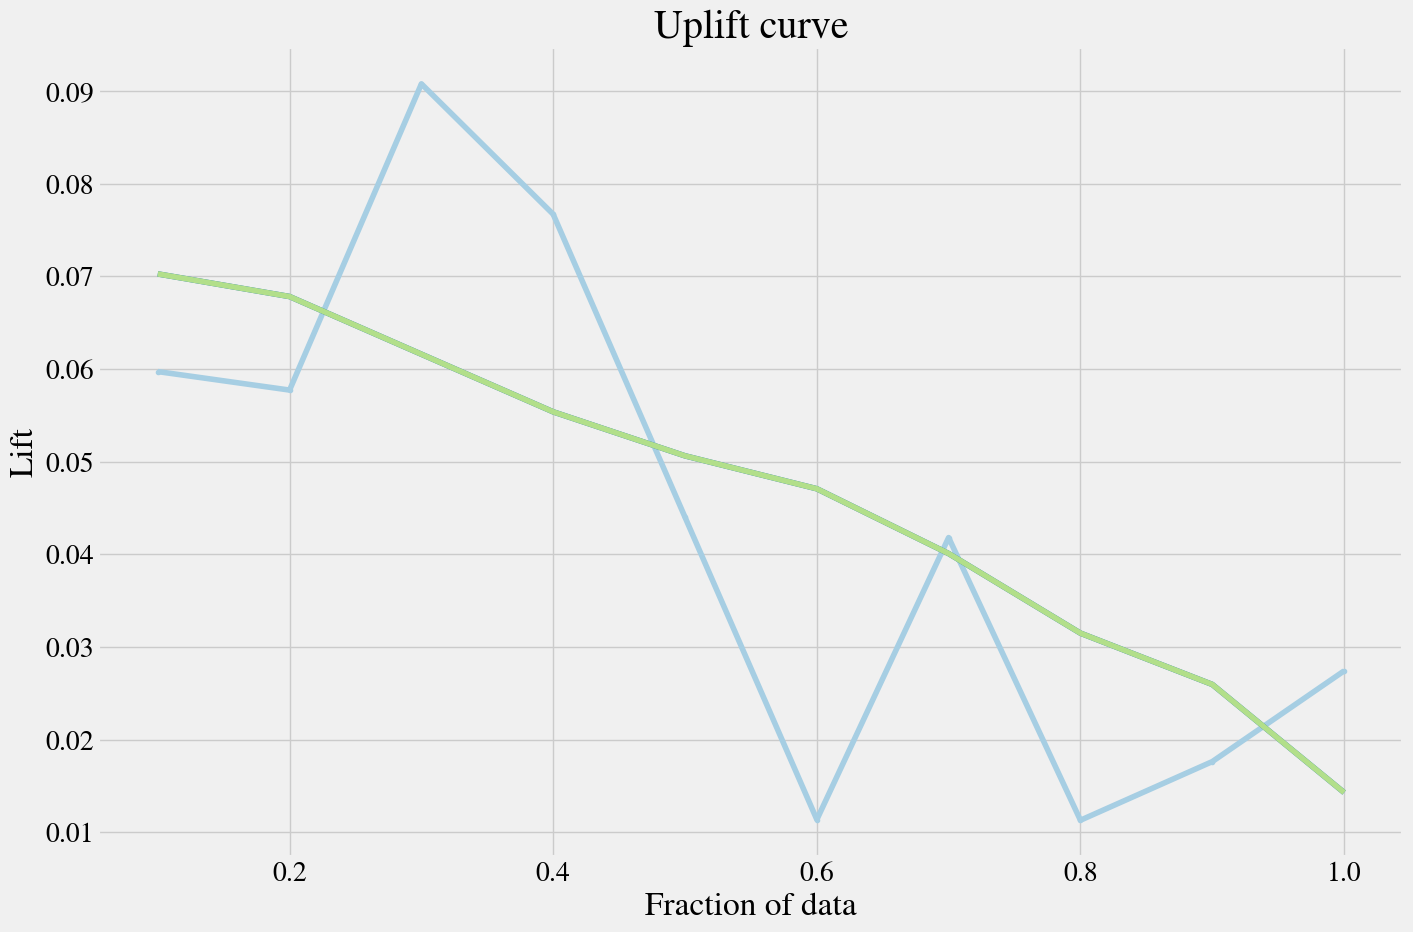

In [84]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10))